### Group 21 : Geoffrey Liu, Varshini Reddy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression as lr


df = pd.read_csv("county.csv")
df = df.drop(['Unnamed: 0', 'state'], axis=1)



In [2]:
qid = ['puma', 'sex', 'age','educ','income','latino','black','asian', 'married']


In [3]:
X =  df.drop(['income', 'puma'], axis=1)
y =  df['income']
model = lr()
model.fit(X,y) 
true_coef = model.coef_
true_int = model.intercept_


In [4]:
duplicates = df.groupby(qid, dropna=False).size().to_frame(name='size').reset_index()
df = pd.merge(df, duplicates, how='left', on=qid)
df


,puma,sex,age,educ,income,latino,black,asian,married,size
0,60100,0,83,9,20500.0,0,0,0,1,1
1,60100,1,81,9,4800.0,0,0,0,1,1
2,60100,0,45,9,12000.0,0,0,0,1,1
3,60100,1,42,12,7200.0,0,0,0,1,1
4,60100,0,35,11,55600.0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1223987,68116,0,58,16,157000.0,0,0,0,1,1
1223988,68116,0,19,9,12000.0,0,0,0,0,9
1223989,68116,0,41,11,85000.0,0,0,0,0,1
1223990,68116,0,21,10,11500.0,0,0,0,0,1


In [5]:
num_bootstraps = 50
num_k = 10

coefficients = np.zeros((num_k, num_bootstraps, len(df.columns)-3))
intercept = np.zeros((num_k, num_bootstraps, 1))

for size in range(num_k): 
    df_temp = df[df['size']>=size+1]
    for i in range(num_bootstraps):
        df1 = df_temp.sample(frac=1, replace=True)
        X =  df1.drop(['income', 'size', 'puma'], axis=1)
        y =  df1['income']
        model = lr()
        model.fit(X,y)    
        coefficients[size,i,:] = model.coef_
        intercept[size,i,:] = model.intercept_

mean_coef = np.mean(coefficients, axis=1)#, np.std(coefficients, axis=1)
mean_int = np.mean(intercept, axis = 1)

In [6]:
col_names = [i.upper() for i in ["intercept","age","education","sex","latino","asian","black","married"]]
col_names


['INTERCEPT', 'AGE', 'EDUCATION', 'SEX', 'LATINO', 'ASIAN', 'BLACK', 'MARRIED']

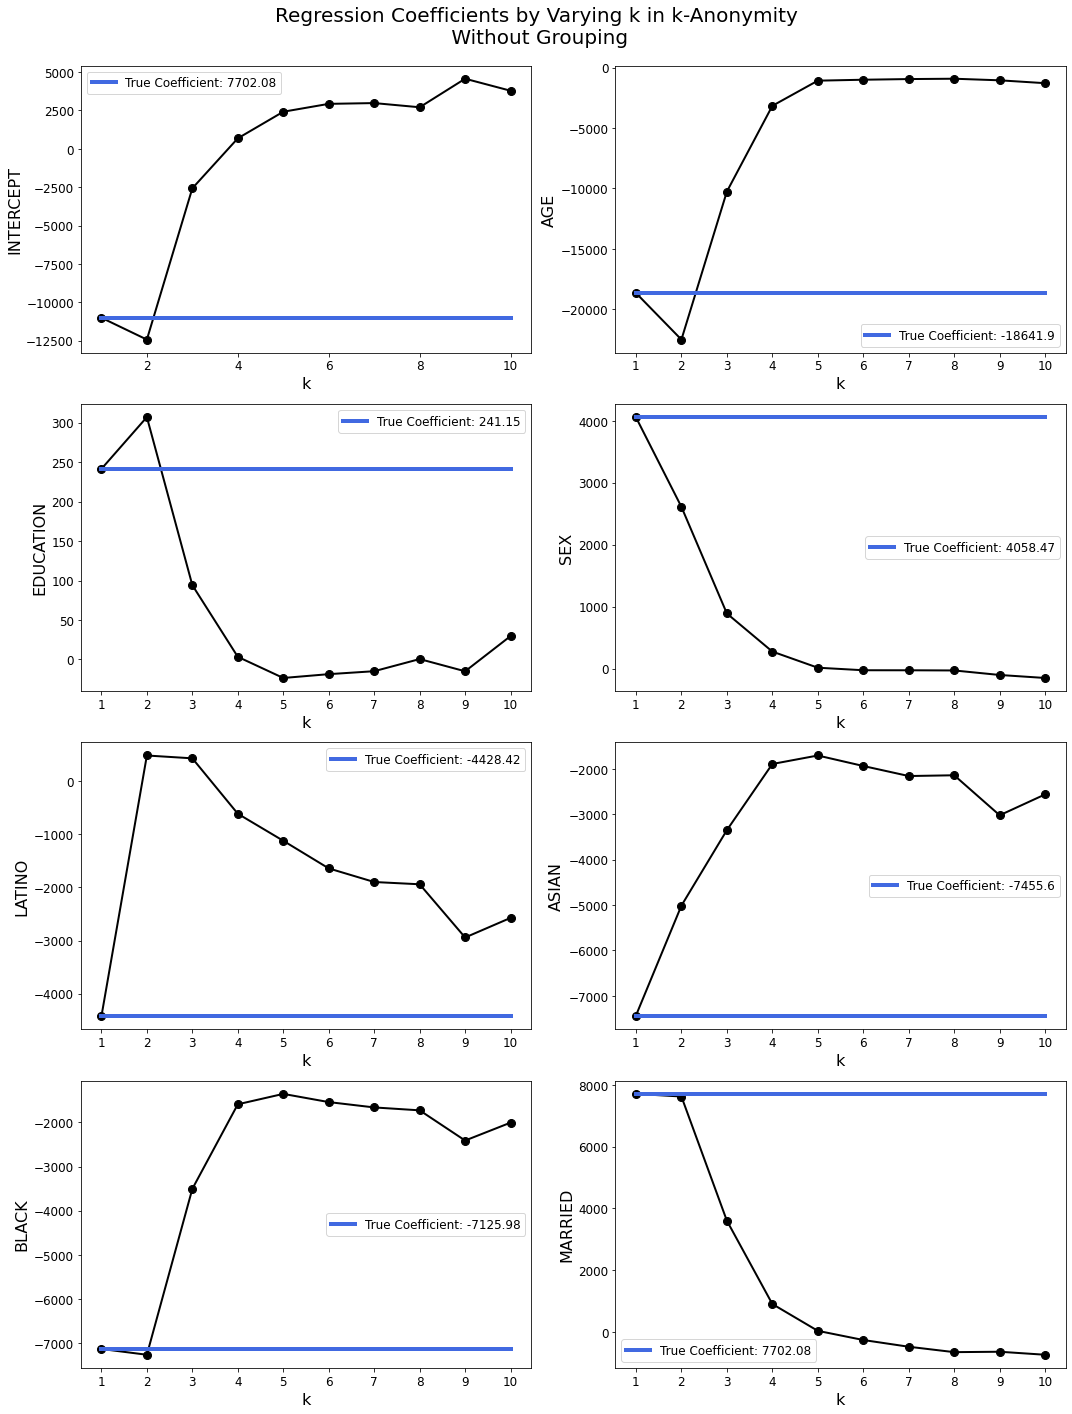

In [7]:
fig, ax = plt.subplots(4,2, figsize=(15,20))
ax = ax.flatten()
k = range(1,11)
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=8)

for i in range(8):
    if i==0:
        ax[i].plot(k, mean_int, linewidth=2, marker='o', c='k',markersize=8)
        ax[i].plot(k, [true_int]*num_k, linewidth=4,label=f"True Coefficient: {round(true_coef[i-1], 2)}", c='royalblue')
        ax[i].set_xlabel("k", fontsize=16)
        # ax[i].set_ylabel(f"{col_names[i]}", fontsize=16)
        # ax[i].set_xticks(range(1,11))
    else:
        ax[i].plot(k, mean_coef[:,i-1], linewidth=2, marker='o', c='k',markersize=8)
        ax[i].plot(k, [true_coef[i-1]]*num_k, linewidth=4, label=f"True Coefficient: {round(true_coef[i-1], 2)}", c='royalblue')
        # ax[i].set_xlabel("k", fontsize=16)
        # ax[i].set_ylabel(fr"{col_names[i]}", fontsize=16)
        ax[i].set_xticks(range(1,11))
    ax[i].set_xlabel("k", fontsize=16)
    ax[i].set_ylabel(f"{col_names[i]}", fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend(fontsize=12)
fig.suptitle("Regression Coefficients by Varying k in k-Anonymity\n Without Grouping\n", fontsize=20)
plt.tight_layout()
plt.savefig('Plots/k_anonymous_wo_group.svg', format='svg', dpi=1200)
plt.show()

In [8]:
num_bootstraps = 50
num_k = 10

coefficients = np.zeros((num_k, num_bootstraps, len(df.columns)-3))
intercept = np.zeros((num_k, num_bootstraps, 1))


for size in range(num_k): 
    df_temp = df[df['size']>=size+1]
    df_temp = df_temp.drop(['size'], axis=1)
    df_temp = df_temp.groupby('puma').agg({"age": lambda x:np.mean(x), 
                                   "educ":lambda x:int(np.random.choice([x.value_counts().index[0], np.mean(x)])),
                                   "sex":lambda x: np.mean(x), 
                                   "latino":lambda x: np.mean(x),
                                    "asian":lambda x: np.mean(x),
                                     "black":lambda x: np.mean(x),
                                    "married":lambda x: np.mean(x),
                                   "income":lambda x:np.mean(x),
                        })
    if size==0:
        X =  df_temp.drop(['income'], axis=1)
        y =  df_temp['income']
        model = lr()
        model.fit(X,y) 
        true_coef = model.coef_
        true_int = model.intercept_

    for i in range(num_bootstraps):        
        df1 = df_temp.sample(frac=1, replace=True)
        X =  df1.drop(['income'], axis=1)
        y =  df1['income']
        model = lr()
        model.fit(X,y)    
        coefficients[size,i,:] = model.coef_
        intercept[size,i,:] = model.intercept_
        
mean_coef = np.mean(coefficients, axis=1)#, np.std(coefficients, axis=1)        
mean_int = np.mean(intercept, axis = 1)

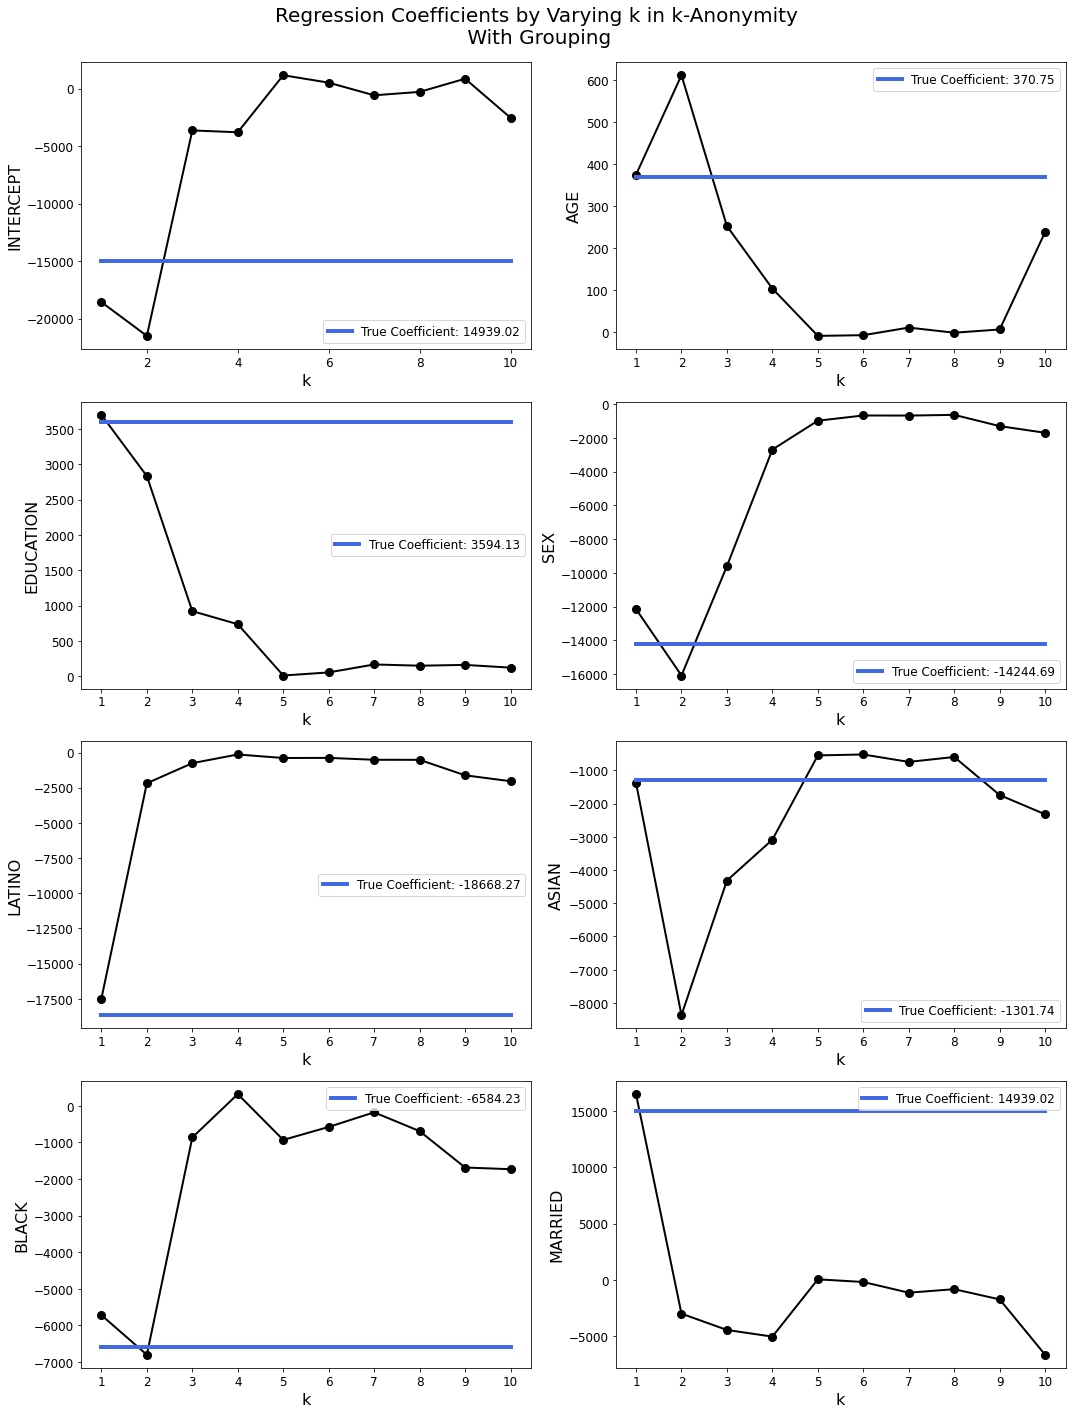

In [9]:
fig, ax = plt.subplots(4,2, figsize=(15,20))
ax = ax.flatten()
k = range(1,11)
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.tick_params(axis='both', which='minor', labelsize=8)

for i in range(8):
    if i==0:
        ax[i].plot(k, mean_int, linewidth=2, marker='o', c='k',markersize=8)
        ax[i].plot(k, [true_int]*num_k, linewidth=4,label=f"True Coefficient: {round(true_coef[i-1], 2)}", c='royalblue')
        ax[i].set_xlabel("k", fontsize=16)
        # ax[i].set_ylabel(f"{col_names[i]}", fontsize=16)
        # ax[i].set_xticks(range(1,11))
    else:
        ax[i].plot(k, mean_coef[:,i-1], linewidth=2, marker='o', c='k',markersize=8)
        ax[i].plot(k, [true_coef[i-1]]*num_k, linewidth=4, label=f"True Coefficient: {round(true_coef[i-1], 2)}", c='royalblue')
        # ax[i].set_xlabel("k", fontsize=16)
        # ax[i].set_ylabel(fr"{col_names[i]}", fontsize=16)
        ax[i].set_xticks(range(1,11))
    ax[i].set_xlabel("k", fontsize=16)
    ax[i].set_ylabel(f"{col_names[i]}", fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend(fontsize=12)
fig.suptitle("Regression Coefficients by Varying k in k-Anonymity\n With Grouping\n", fontsize=20)
plt.tight_layout()
plt.savefig('Plots/k_anonymous_with_group.svg', format='svg', dpi=1200)
plt.show()


# DP DATA VIZ

In [10]:
df = pd.read_csv("aggregated.csv")
df.head()

,age,educ,sex,latino,asian,black,married,income
0,48.786803,9,0.484272,0.084160,0.011184,0.024745,0.635677,21817.919195
1,45.471032,10,0.518804,0.045158,0.014520,0.009002,0.513867,23494.136489
2,48.768035,10,0.522246,0.041901,0.020446,0.005760,0.603888,25294.344420
3,49.384259,9,0.513374,0.106824,0.014403,0.015947,0.551269,24315.618313
4,48.171670,9,0.502028,0.167775,0.012818,0.005192,0.624371,21607.807886


In [11]:
X = df.drop(['income'], axis=1)
y = df['income']
model = lr()
model.fit(X,y) 
true_coef = model.coef_
true_int = model.intercept_


In [12]:
df = pd.read_csv("viz_df.csv")
df.head()


,epsilon,variable,mean,sd
0,0.01,b0,15058.976970,4593.071519
1,0.01,b1,294.639225,102.851065
2,0.01,b2,304.428738,107.427514
3,0.01,b3,-1.084162,113.379370
4,0.01,b4,-29.734971,111.392504


In [13]:
epsilons = np.unique(df.epsilon)
coef = np.unique(df.variable)


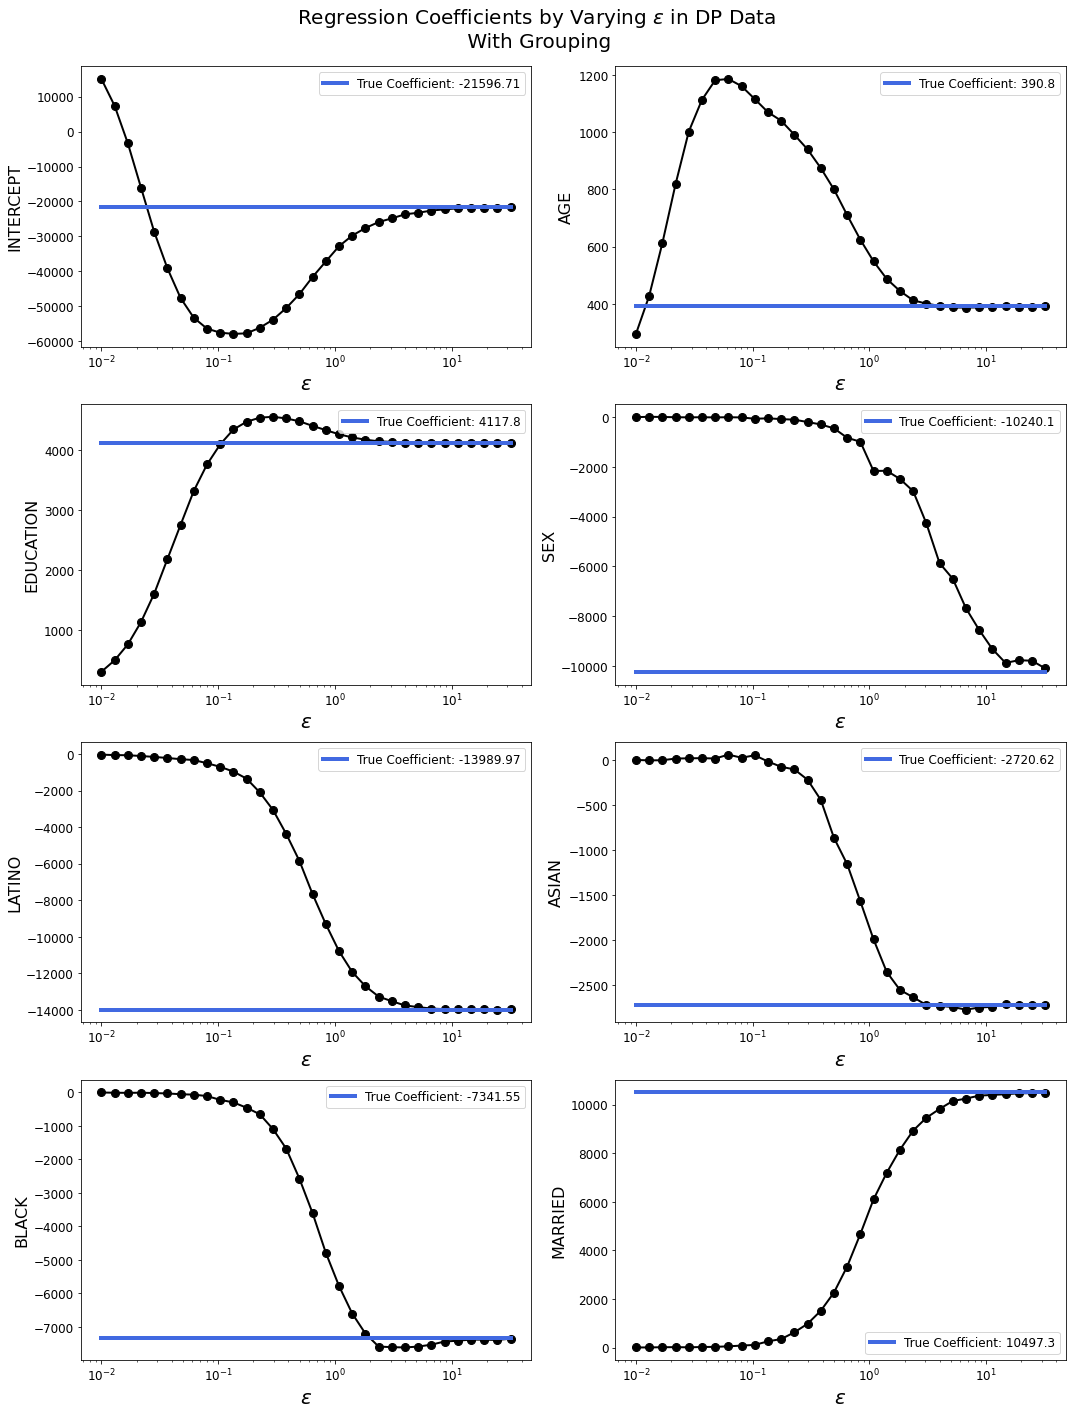

In [14]:
fig, ax = plt.subplots(4,2, figsize=(15,20))
ax = ax.flatten()
# k = range(1,11)

for i in range(8):
    ax[i].plot(epsilons, df['mean'][df['variable']==coef[i]], linewidth=2, marker='o', c='k',markersize=8)
    if i==0:
        ax[i].plot(epsilons, [true_int]*len(epsilons), linewidth=4,label=f"True Coefficient: {round(true_int, 2)}", c='royalblue')
    else:
        ax[i].plot(epsilons, [true_coef[i-1]]*len(epsilons), linewidth=4,label=f"True Coefficient: {round(true_coef[i-1], 2)}", c='royalblue')
    ax[i].set_xlabel(f"$\epsilon$", fontsize=20)
    ax[i].set_ylabel(f"{col_names[i]}", fontsize=16)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend(fontsize=12)
    ax[i].set_xscale('log')
    # ax[i].set_xticks(range(1,11))
# fig.delaxes(ax[7])
fig.suptitle(f"Regression Coefficients by Varying $\epsilon$ in DP Data\n With Grouping\n", fontsize=20)
plt.tight_layout()
plt.savefig('Plots/dp_with_group.svg', format='svg', dpi=1200)
plt.show()

